# Implementation of deep NN using numpy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Preparing the model dataset

### Import the Titanic dataset (from Kaggle)

In [2]:
df = pd.read_csv('train.csv')
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


array([[<AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

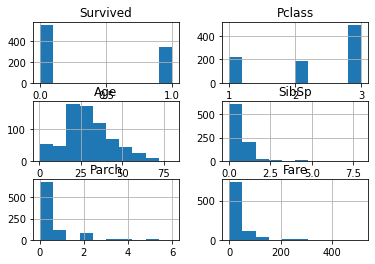

In [3]:
df.hist(column=['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'])

<AxesSubplot:>

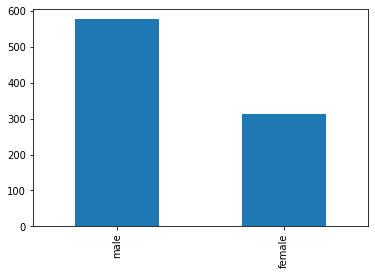

In [4]:
df['Sex'].value_counts().plot(kind='bar')

<AxesSubplot:>

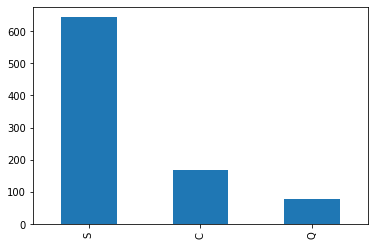

In [5]:
df['Embarked'].value_counts().plot(kind='bar')

### One-hot encode columns of categorical values

In [6]:
df_sex = pd.get_dummies(df['Sex'], prefix='Sex')
df_sex.head()

,Sex_female,Sex_male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


In [7]:
df_embarked = pd.get_dummies(df['Embarked'], prefix='Embarked')
df_embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


### Create numpy arrays to store both input data and y

In [8]:
# number of observations
m = df.shape[0]

In [9]:
# array for Y
Y = np.array(df['Survived']).reshape(1, m)
Y.shape

(1, 891)

In [10]:
df[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500
...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000
887,1,1,19.0,0,0,30.0000
888,0,3,NaN,1,2,23.4500
889,1,1,26.0,0,0,30.0000


In [11]:
# get a dataframe with only numerical input variables
df_X = pd.concat([df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']], df_sex['Sex_female'], 
                  df_embarked[['Embarked_C', 'Embarked_Q']]], axis=1, join='inner')
print("df_X.shape =", df_X.shape)
df_X.head(5)

df_X.shape = (891, 8)


,Pclass,Age,SibSp,Parch,Fare,Sex_female,Embarked_C,Embarked_Q
0,3,22.0,1,0,7.2500,0,0,0
1,1,38.0,1,0,71.2833,1,1,0
2,3,26.0,0,0,7.9250,1,0,0
3,1,35.0,1,0,53.1000,1,0,0
4,3,35.0,0,0,8.0500,0,0,0


In [12]:
# find columns with missing values
columns_with_missing = []
for column in df_X.columns:
    if len(list(df_X[column].isna().value_counts())) > 1:
        columns_with_missing.append(column)

print("Columns with missing values:", columns_with_missing)

Columns with missing values: ['Age']


In [13]:
# impute the missing with column mean
df_X.fillna(value=df_X['Age'].mean(), inplace=True)

df_X['Age'].isna().value_counts()

False    891
Name: Age, dtype: int64

In [14]:
# create a numpy array of dimension (n_x, m) to hold the input data
n_x = df_X.shape[1]
X = df_X.to_numpy().T

X.shape

(8, 891)

In [15]:
# spot check if X has been created properly 
X

array([[ 3.        ,  1.        ,  3.        , ...,  3.        ,
         1.        ,  3.        ],
       [22.        , 38.        , 26.        , ..., 29.69911765,
        26.        , 32.        ],
       [ 1.        ,  1.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  1.        ,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

# Create helper functions needed for forward prop and back prop

In [16]:
Z_test = np.array([[1, -2, 3], [4, 5, -6]])
Z_test

array([[ 1, -2,  3],
       [ 4,  5, -6]])

In [17]:
Y_test = np.array([[1, 0, 1]])
Yhat_test = np.array([[0.3, 0.2, 0.1]])
print(Y_test.shape)
print(Yhat_test.shape)

(1, 3)
(1, 3)


In [18]:
A_test = np.array([[1, -2, 3], [-4, -5, 6]])
W_test = np.array([[3, -5], [0.5, -1], [-2, 1.5]])
b_test = np.array([[0], [0.1], [-2.3]])
print("A_test.shape:", A_test.shape)
print("W_test.shape:", W_test.shape)
print("b_test.shape:", b_test.shape)

A_test.shape: (2, 3)
W_test.shape: (3, 2)
b_test.shape: (3, 1)


### Sigmoid

In [19]:
def sigmoid(Z):
    """
    This function returns the sigmoid transformation of the input array Z.
    """
    
    return 1 / (1 + np.exp(-Z))


# test
A_test = sigmoid(Z_test)
print(A_test.shape)
print(A_test)

(2, 3)
[[0.73105858 0.11920292 0.95257413]
 [0.98201379 0.99330715 0.00247262]]


In [20]:
def sigmoid_prime(Z, sigmoid_func=sigmoid):
    """
    This function returns the derivative of Sigmoid of the input Z.
    """
    
    return np.multiply(sigmoid_func(Z), (1 - sigmoid_func(Z)))


# test
dgdZ_test = sigmoid_prime(Z_test)
print(dgdZ_test.shape)
print(dgdZ_test)

(2, 3)
[[0.19661193 0.10499359 0.04517666]
 [0.01766271 0.00664806 0.00246651]]


### Relu and its derivative

In [21]:
def ReLu(Z):
    """
    This function returns the ReLu transformation of the input array Z.
    """
    
    return np.maximum(0, Z)


# test
A_test = ReLu(Z_test)
print(A_test.shape)
print(A_test)

(2, 3)
[[1 0 3]
 [4 5 0]]


In [22]:
def ReLu_prime(Z):
    """
    This function returns the derivative of Relu of the input array Z.
    """
    
    return np.where(Z < 0, 0, 1)


# test
A_test = ReLu_prime(Z_test)
print(A_test.shape)
print(A_test)

(2, 3)
[[1 0 1]
 [1 1 0]]


### Cost function for the logistic regression model

In [23]:
def cost_logistic(Y, Yhat):
    """
    This function returns the cost of a logistic regression, given Y and Yhat.
    """
    
    return -(np.multiply(Y, np.log(Yhat)) + np.multiply((1 - Y), np.log(1 - Yhat)))


# test
print("Y_test =", Y_test)
print("Yhat_test =", Yhat_test)
cost_test = cost_logistic(Y_test, Yhat_test)
print("cost_test =", cost_test)

Y_test = [[1 0 1]]
Yhat_test = [[0.3 0.2 0.1]]
cost_test = [[1.2039728  0.22314355 2.30258509]]


### Function to compute dA of the last layer L

In [24]:
def dAL(Y, AL):
    """
    This function returns dA of layer L (the last layer), given Y and A of layer L.
    """
    
    return -Y / AL + (1 - Y) / (1 - AL)

    
# test
print("Y_test =", Y_test)
print("AL_test =", Yhat_test)
print("dAL_test =", dAL(Y_test, Yhat_test))

Y_test = [[1 0 1]]
AL_test = [[0.3 0.2 0.1]]
dAL_test = [[ -3.33333333   1.25       -10.        ]]


### Funtion to perform one layer of forward pass

In [25]:
def forward_prop(A_in, W, b, g):
    """
    This function computes the activisions of the current layer "l", vectorized.
    
    Inputs:
        "A_in" - a numpy array of (n[l-1], m), activisions of the previous layer
        "W" - a numpy array of (n[l], n[l-1]), weights of the current layer
        "b" - a numpy array of (n[l], 1), intercepts of the current layer
        "g" - a function object, the activision function of the current layer
    """
    
    Z_out = np.dot(W, A_in) + b
    A_out = g(Z_out)
    
    return Z_out, A_out


# test
print("A_in =", A_test)
print("W =", W_test)
print("b =", b_test)
Z_out_test, A_out_test = forward_prop(A_test, W_test, b_test, g=ReLu)
print("Z_out =", Z_out_test)
print("A_out =", A_out_test)

A_in = [[1 0 1]
 [1 1 0]]
W = [[ 3.  -5. ]
 [ 0.5 -1. ]
 [-2.   1.5]]
b = [[ 0. ]
 [ 0.1]
 [-2.3]]
Z_out = [[-2.  -5.   3. ]
 [-0.4 -0.9  0.6]
 [-2.8 -0.8 -4.3]]
A_out = [[0.  0.  3. ]
 [0.  0.  0.6]
 [0.  0.  0. ]]


### Function to perform one layer of backprop 

In [26]:
def back_prop(dA_l, Z_l, W_l, A_lmone, g_prime, m):
    """
    This function performs one layer of back prop.
    
    It takes dA of layer l as the input, and returns dW of layer l, db of layer l, 
    and dA of layer l-1 as the outputs.
    
    Inputs:
        "dA_l": a numpy array of dimension (n[l], m) for dA of layer l, where n[l] is the number of 
        neurons in layer l,
                and m is the number of observations
        "Z_l": a numpy array of dimension (n[l], m) for Z of layer l
        "W_l": a numpy array of dimension (n[l], n[l-1]) for W of layer l, where n[l-1] is the number of neurons in layer l-1
        "A_lmone": a numpy array of dimension (n[l-1], m) for activisions of layer l-1
        "g_prime": a function object for the derivative of the activition function of layer l 
        "m": number of observations in the training sample
    """
    
    dZ_l = np.multiply(dA_l, g_prime(Z_l))
    dW_l = np.dot(dZ_l, A_lmone.T) / m
    db_l = np.sum(dZ_l, axis=1, keepdims=True) / m
    dA_lmone = np.dot(W_l.T, dZ_l)
    
    return dW_l, db_l, dA_lmone


# test 
# assume the current layer "l" has 3 units, and the previous layer "l-1" has 2
# assume there are 3 observations (m = 3)
dA_test = np.array([[5, 3, 1], [2, 4, -6], [-0.3, 5, -0.7]])
Z_test = np.array([[-2, 3, -4], [0, 1, -5], [1, -2, 0.5]])
print("dA_l =", dA_test)
print("Z_l =", Z_test)
print("W_l =", W_test)
print("A_lmone =", A_test)
print("g_prime is ReLu_prime")
print("m =", 3)

dW_l_test, db_l_test, dA_lmone_test = back_prop(dA_test, Z_test, W_test, A_test, ReLu_prime, 3)

print("dW_l =", dW_l_test)
print("db_l =", db_l_test)
print("dA_lmone =", dA_lmone_test)

dA_l = [[ 5.   3.   1. ]
 [ 2.   4.  -6. ]
 [-0.3  5.  -0.7]]
Z_l = [[-2.   3.  -4. ]
 [ 0.   1.  -5. ]
 [ 1.  -2.   0.5]]
W_l = [[ 3.  -5. ]
 [ 0.5 -1. ]
 [-2.   1.5]]
A_lmone = [[1 0 1]
 [1 1 0]]
g_prime is ReLu_prime
m = 3
dW_l = [[ 0.          1.        ]
 [ 0.66666667  2.        ]
 [-0.33333333 -0.1       ]]
db_l = [[ 1.        ]
 [ 2.        ]
 [-0.33333333]]
dA_lmone = [[  1.6   11.     1.4 ]
 [ -2.45 -19.    -1.05]]


### Test setup for end to end forward and backward passes

In [27]:
# set up test inputs
# assume a 3-layer neural net, with n_0 or n_x = 2, n_1 = 3, n_2 = 2, n_3 = 1
# assume m = 3
X_test = np.array([[1, 2, -1], 
                   [-4, 0, 3]])
Y_test = np.array([[0, 0, 1]])
num_layers_test = 3
W_list_test = [
    None,
    np.array([[0.5, -1.6],
              [2.3, 1.2],
              [0.2, 0.7]]),
    np.array([[2.0, -0.2, 1.5],
              [-1, 0.2, 0.7]]),
    np.array([[0.4, -1.3]])
]
b_list_test = [
    None,
    np.array([[0.0], 
              [2.3], 
              [-1.9]]),
    np.array([[1.5],
              [-0.7]]),
    np.array([[1.0]])
]
g_list_test = [
    None,
    ReLu,
    ReLu,
    sigmoid
]
gprime_list_test = [
    None,
    ReLu_prime,
    ReLu_prime,
    sigmoid_prime
]

### Function to perform a full forward pass

In [28]:
def forward_prop_full(X, Y, num_layers, W_list, b_list, g_list):
    """
    This function does a full round of forward pass from the first to the last layer of the neural network,
    and returns the Z & A of each layer, as well as the value of the cost function.
    """
    
    if len(W_list) != num_layers + 1 or len(b_list) != num_layers + 1 or len(g_list) != num_layers + 1:
        raise Exception("Invalid length for input list(s).")
    
    # initialize the list for Z and A, both with X to represent Z and A of layer 0, the input layer
    Z_list = [X]
    A_list = [X]
    
    # loop through all layers
    # layer indexed 0 represents the first layer after the input layer
    for i in range(1, num_layers+1):
        A_in = A_list[i-1]
        
        # perform one layer of forward pass
        Z_out, A_out = forward_prop(A_in, W_list[i], b_list[i], g_list[i])
        
        # append the output Z and A of the current layer to the output lists
        Z_list.append(Z_out)
        A_list.append(A_out)
        
    # compute the updated value for the logistic cost function
    J = -(np.multiply(Y, np.log(A_list[-1])) + np.multiply((1 - Y), np.log(1 - A_list[-1])))
    J = np.sum(J, axis=1) / Y.shape[1]
    
    return Z_list, A_list, J


# run a full forward pass
Z_list_test, A_list_test, J_test = forward_prop_full(X=X_test,
                                                     Y=Y_test,
                                                     num_layers=num_layers_test,
                                                     W_list=W_list_test,
                                                     b_list=b_list_test,
                                                     g_list=g_list_test)

# print out results
print("Z_list_test:")
print(Z_list_test)
print("A_list_test:")
print(A_list_test)
print("J_test =", J_test)

Z_list_test:
[array([[ 1,  2, -1],
       [-4,  0,  3]]), array([[ 6.9,  1. , -5.3],
       [-0.2,  6.9,  3.6],
       [-4.5, -1.5,  0. ]]), array([[15.3 ,  2.12,  0.78],
       [-7.6 , -0.32,  0.02]]), array([[7.12 , 1.848, 1.286]])]
A_list_test:
[array([[ 1,  2, -1],
       [-4,  0,  3]]), array([[6.9, 1. , 0. ],
       [0. , 6.9, 3.6],
       [0. , 0. , 0. ]]), array([[15.3 ,  2.12,  0.78],
       [ 0.  ,  0.  ,  0.02]]), array([[0.99919189, 0.86389211, 0.78346938]])]
J_test = [3.11971304]


### Function to perform a full backward pass

In [29]:
def backward_prop_full(Z_list, A_list, Y, num_layers, W_list, gprime_list):
    """
    This function performs a full round of backward propagation through all layers in the neural net,
    and returns the gradients of W & b for each layer in a list.
    """
    
    # check inputs
    # the input lists' lengths should be equal to num_layers + 1 because they all include 
    # an item for layer 0, while the num_layers only count layers that are not layer 0
    if len(W_list) != num_layers + 1 or len(gprime_list) != num_layers + 1:
        raise Exception("Lengths of inputs do not match.")
        
    # set the number of observation to what's implied by the input vector
    m = Y.shape[1]
        
    # initialize the backward pass by calculating dA of the last layer
    YHat = A_list[-1]
    dAL = -Y / YHat + (1 - Y) / (1 - YHat)
    
    # loop through all layers from the last to the first, and perform backward prop sequentially for each layer
    dA_lmone = None
    dW_list = []
    db_list = []
    
    # loop through the layers in reversed order, from the last layer down the the first layer after the input layer
    for l in range(num_layers, 0, -1):
        
        # get dA of the current layer
        if l == num_layers:
            dA_l = dAL
        else:
            dA_l = dA_lmone
            
        # run backward prop for the current layer
        dW, db, dA_lmone = back_prop(dA_l, Z_list[l], W_list[l], A_list[l-1], gprime_list[l], m)
        
        # append the gradients of W and b to the beginning of the output list for W & b for all layers
        dW_list.insert(0, dW)
        db_list.insert(0, db)
        
    # insert None to the beginning of both output lists to represent the value for layer 0
    dW_list.insert(0, None)
    db_list.insert(0, None)
        
    return dW_list, db_list


# test using the test setup above as well as outputs from the full forward pass test run
dW_list_test, db_list_test = backward_prop_full(Z_list_test, 
                                                A_list_test, 
                                                Y_test, 
                                                num_layers_test, 
                                                W_list_test, 
                                                gprime_list_test)
print("Z_list_test:", Z_list_test)
print("A_list_test:", A_list_test)
print("Y_test:", Y_test)
print("num_layers_test:", num_layers_test)
print("gprime_list_test:", gprime_list_test)
print("W_list_test:", W_list_test)
print("dW_list_test:", dW_list_test)
print("b_list_test:", b_list_test)
print("db_list_test:", db_list_test)

Z_list_test: [array([[ 1,  2, -1],
       [-4,  0,  3]]), array([[ 6.9,  1. , -5.3],
       [-0.2,  6.9,  3.6],
       [-4.5, -1.5,  0. ]]), array([[15.3 ,  2.12,  0.78],
       [-7.6 , -0.32,  0.02]]), array([[7.12 , 1.848, 1.286]])]
A_list_test: [array([[ 1,  2, -1],
       [-4,  0,  3]]), array([[6.9, 1. , 0. ],
       [0. , 6.9, 3.6],
       [0. , 0. , 0. ]]), array([[15.3 ,  2.12,  0.78],
       [ 0.  ,  0.  ,  0.02]]), array([[0.99919189, 0.86389211, 0.78346938]])]
Y_test: [[0 0 1]]
num_layers_test: 3
gprime_list_test: [None, <function ReLu_prime at 0x7f569ba74670>, <function ReLu_prime at 0x7f569ba74670>, <function sigmoid_prime at 0x7f569ba74820>]
W_list_test: [None, array([[ 0.5, -1.6],
       [ 2.3,  1.2],
       [ 0.2,  0.7]]), array([[ 2. , -0.2,  1.5],
       [-1. ,  0.2,  0.7]]), array([[ 0.4, -1.3]])]
dW_list_test: [None, array([[ 0.72719363, -1.06580468],
       [-0.07061438,  0.07362041],
       [-0.02237483,  0.06712449]]), array([[1.03444215, 0.69084604, 0.        ],

# Train a deep neural network to fit to the Titanic dataset 

### Set up & initialize the network

In [30]:
num_layers_test = 3
W_list = [
    None,
    np.random.randn(2, 8)*0.01,
    np.random.randn(3, 2)*0.01,
    np.random.randn(1, 3)*0.01
]
b_list = [
    None,
    np.zeros((2, 1)),
    np.zeros((3, 1)),
    np.zeros((1, 1))
]
g_list = [
    None,
    ReLu,
    ReLu,
    sigmoid
]
gprime_list = [
    None,
    ReLu_prime,
    ReLu_prime,
    sigmoid_prime
]